<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

## Задача проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.


**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

**Этапы работы**

Наша цель – создать модель, которая берет один комментарий и выдает или 1 (что будет указывать на токсичный комментарий), или 0.

Работу будем проводить в 2 этапа: 

1) C помощью DistilBERT обработаем комментарии и передадим извлеченную им информацию в следующие модели. DistilBERT представляет собой уменьшенную версию BERT'а, она быстрее и легче своего старшего собрата, но при этом вполне сравнима в результативности.

2) Подберем оптимальные гиперпараметры для следующих моделей: LogisticRegression, LGBMClassifier, CatBoostClassifier и выберем модель, которая даст нам наилучший результат f1.


## Подготовка данных 

### Знакомство с данными

In [1]:
#импортируем необходимые библиотеки и алгоритмы
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install torch
import torch
!pip install transformers
import transformers as ppb # pytorch transformers
from tqdm import notebook
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
!pip install catboost
!pip install lightgbm
import lightgbm
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
!pip install sweetviz -q
import sweetviz as sv

In [2]:
#прочтем файл с данными, выведем общую информацию:
df = pd.read_csv('C:/Users/crupi/Downloads/toxic_comments.csv')
display(df.head())
df.info()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Почти 160 тысяч строк! Посмотрим отчет о данных. 

                                             |                                             | [  0%]   00:00 ->…


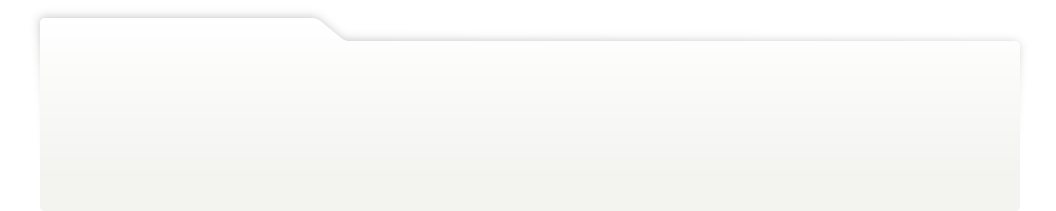
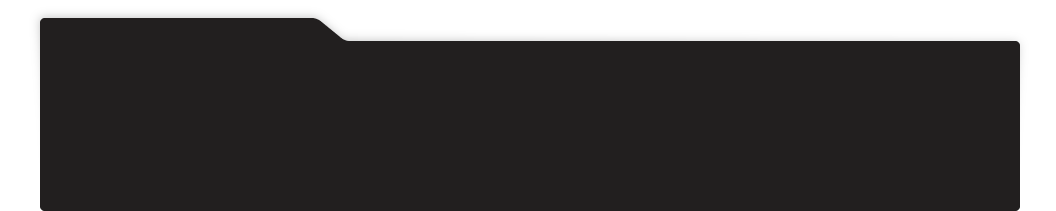
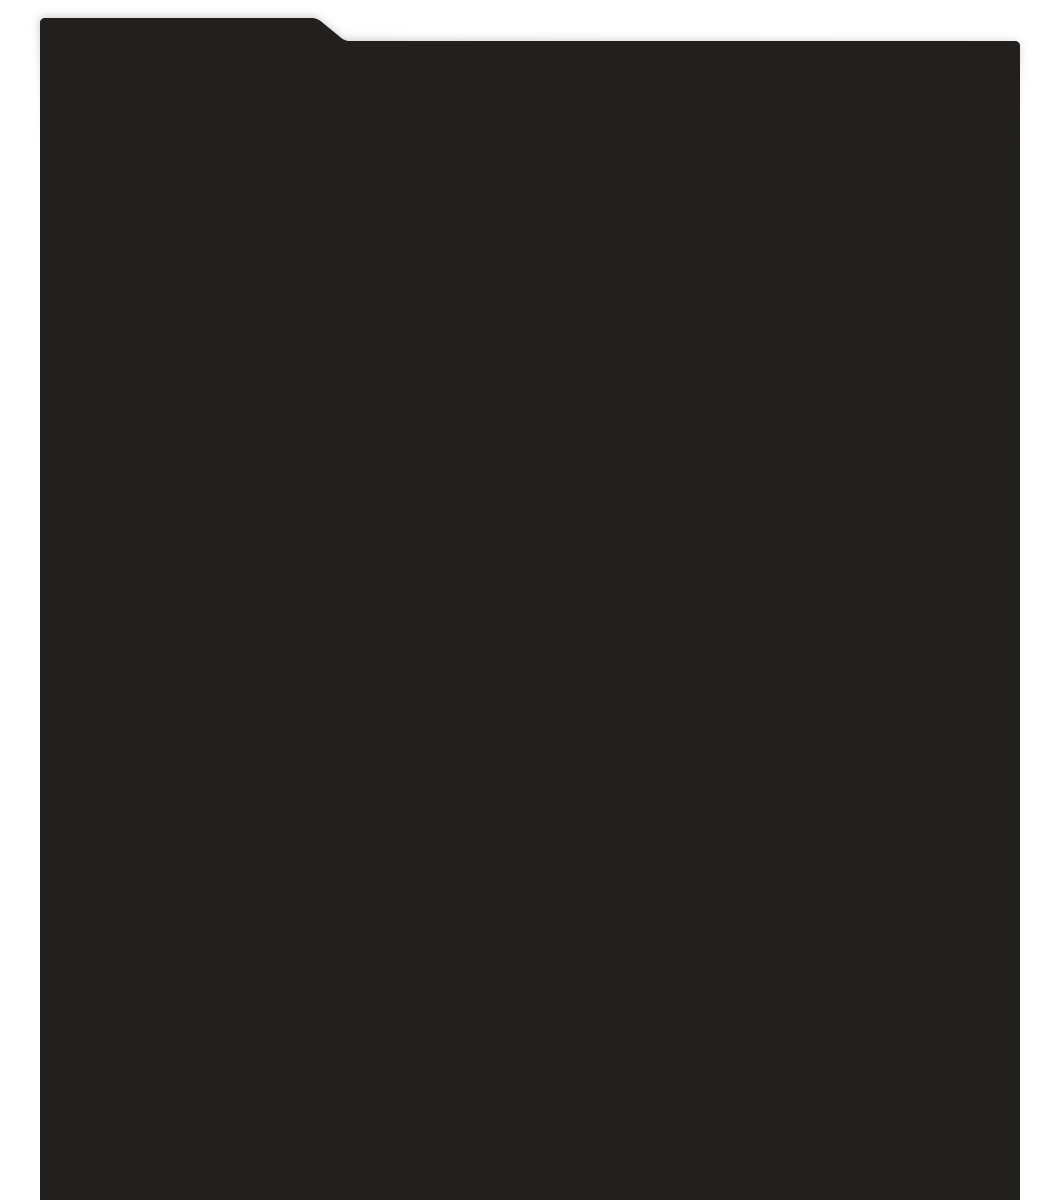
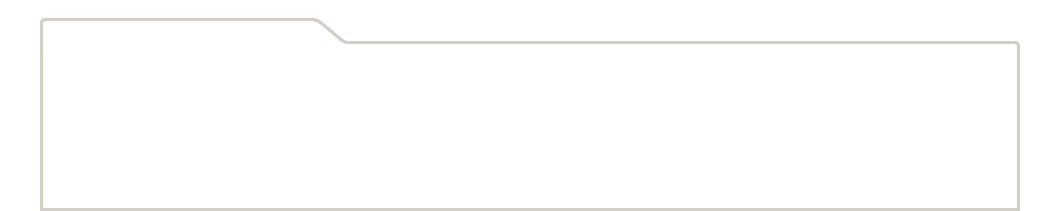
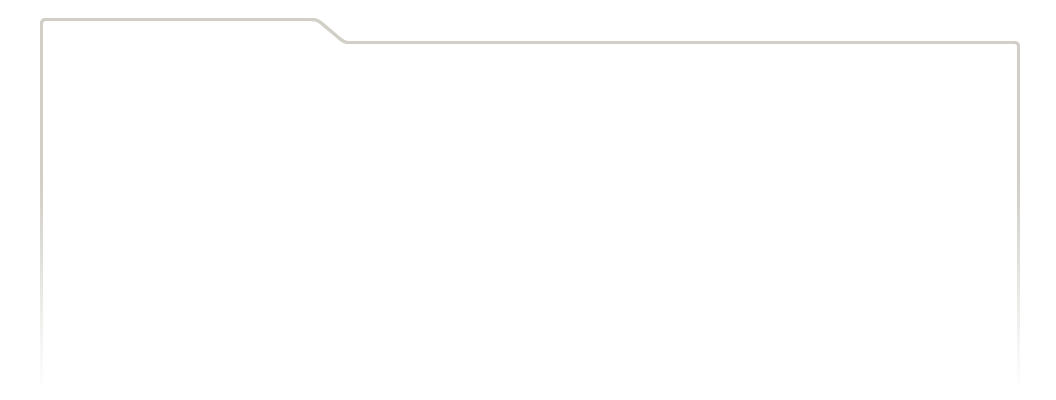
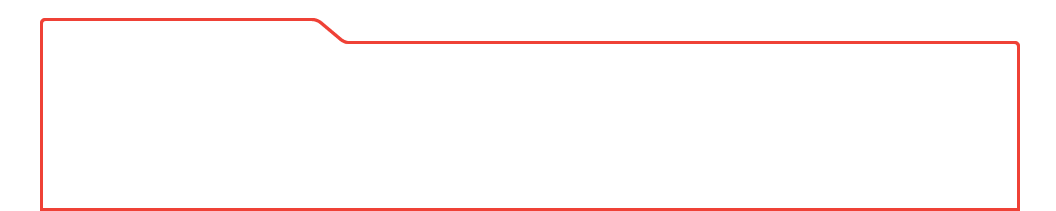
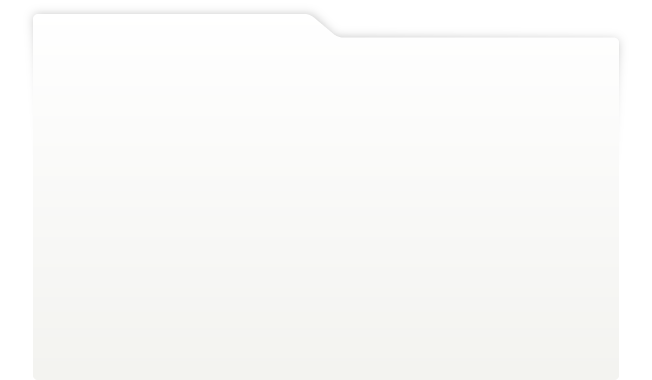
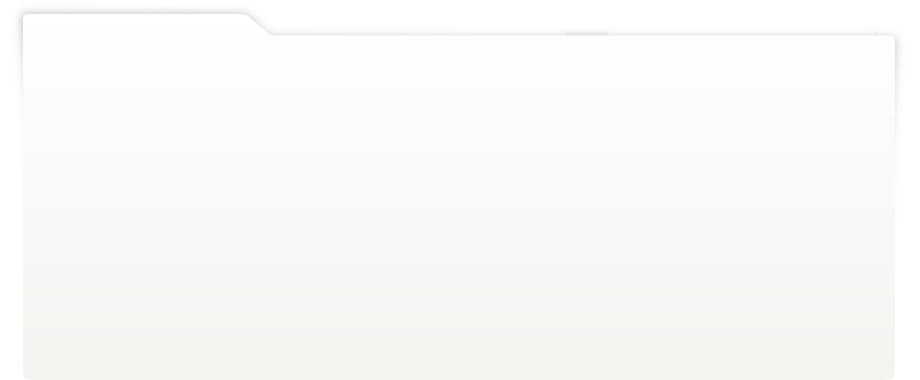
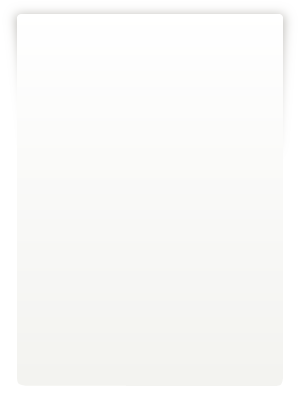
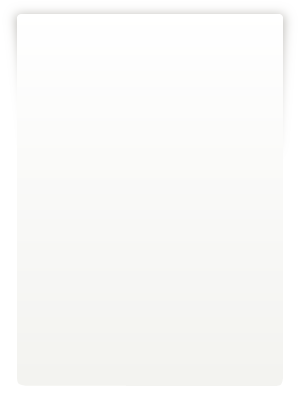
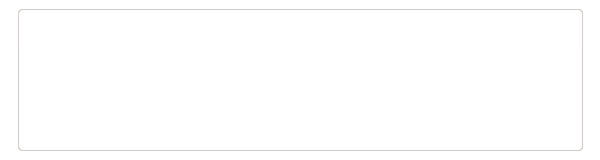
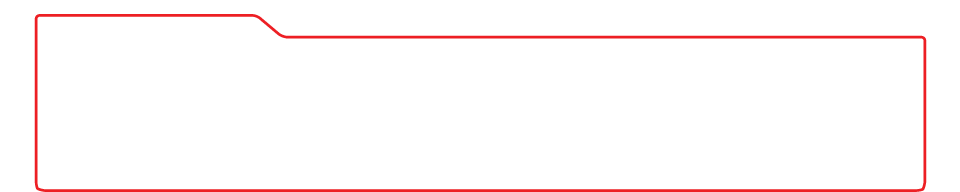
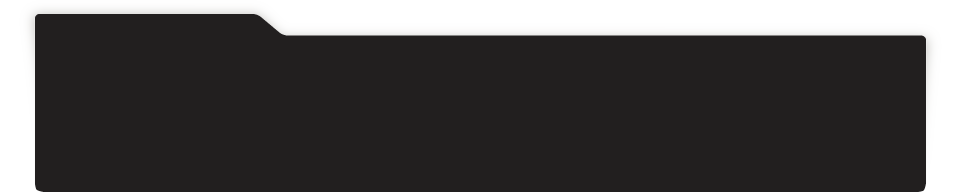
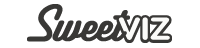
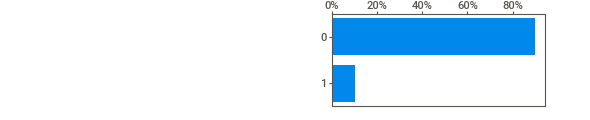
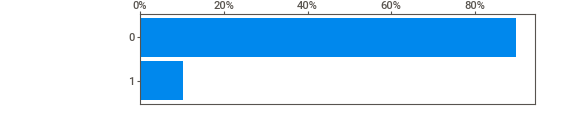
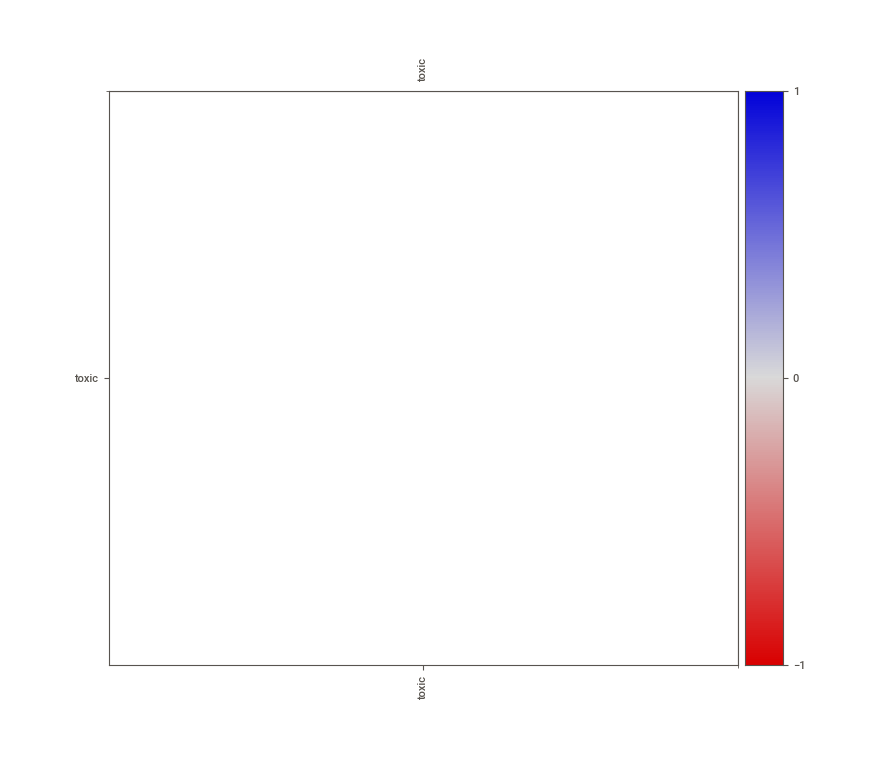
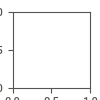

In [3]:
#посмотрим отчет о данных в таблице:
report = sv.analyze(df)
report.show_notebook()

Дубликаты не выявлены, все комментарии уникальные. Соотношение 0 и 1 в целевом столбце - 9 к 1. С данными мы ознакомились, перейдем к подготовке. 

Так как данных слишком много, возьмем для анализа 16000 случайных комментариев (10%).

In [4]:
#создадим новую переменную data с 16000 случайных комментариев: 
data = df.sample(16000).reset_index(drop=True)

### Подготовка данных

Загрузим предобученную модель DistilBERT и токенизатор:

In [5]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Теперь мы можем токенизировать набор данных.

In [14]:
#токенизация:
tokenized = data['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512)))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Этот код преобразует каждое предложение в список идентификаторов. Набор данных теперь представляет собой список (или объект Series/DataFrame из pandas) списков. Прежде чем DistilBERT обработает его на входе, мы должны привести векторы к одному размеру путем прибавления к более коротким векторам идентификатора 0 (padding). 

In [15]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

np.array(padded).shape

(16000, 512)

Мы не можем напрямую отправить padded модели, создадим переменную, которая будет "маскировать" добавленные нами отступы: 

In [16]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(16000, 512)

C помощью цикла по батчам получим список эмбеддингов:

In [17]:
batch_size = 100

embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
    embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/160 [00:00<?, ?it/s]

Соберем все эмбеддинги в матрицу признаков:

In [69]:
#признаки:
features = np.concatenate(embeddings)
features = pd.DataFrame(features)

Чтобы заново не получать признаки при доработке кода сохраним файл с признаками:

In [99]:
features.to_csv('features.csv')

Первая часть работы завершена.  DistilBERT справилась со своей задачей. Мы подготовили признаки для дальнейшего обучения моделей. Теперь разделим данные на обучающую, валидационную и тестовую выборку в соотношении 3/1/1. 

### Подготовка выборок

In [70]:
#целевой признак:
target = data['toxic']

In [81]:
#выделим 20% данных для тестовой выборки(features_test, target_test):
features_without_test, features_test, target_without_test, target_test = train_test_split(
    features, target, test_size=0.2, random_state=1000000, shuffle=True, stratify=target)
#выделим 25% от оставшихся данных для валид-ной выборки(features_valid, target_valid),ост.- обучающая (features_train, target_train):
features_train, features_valid, target_train, target_valid = train_test_split(
    features_without_test, target_without_test, test_size=0.25, random_state=1000000, shuffle=True, stratify=target_without_test)
#для проверки выведем на экран размеры получившихся выборок методом shape: 
display('Размер features и target обучающей выборки:', features_train.shape, target_train.shape)
display('Размер features и target валидационной и тестовой выборок:', features_valid.shape, target_valid.shape, features_test.shape, target_test.shape)

'Размер features и target обучающей выборки:'

(9600, 768)

(9600,)

'Размер features и target валидационной и тестовой выборок:'

(3200, 768)

(3200,)

(3200, 768)

(3200,)

При первичном анализе был выявлен дисбаланс классов (Соотношение 0 и 1 в целевом столбце - 9 к 1). Избавимся от дисбаланса с помощью техники upsampling. 

Создадим функцию, которая на выходе даст обучающую выборку, увеличенную по технике upsampling. 

In [82]:
#запишем функцию
def upsampling (features, target, repeat):
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones = target[target==1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=1000000)
    return features_upsampled, target_upsampled

In [83]:
#получим новую обучающую выборку: 
features_upsampled, target_upsampled = upsampling(features_train, target_train, 9)
#для проверки выведем на экран размеры получившихся выборок: 
display('Размер features_upsampled и target_upsampled :', features_upsampled.shape, target_upsampled.shape)

'Размер features_upsampled и target_upsampled :'

(17424, 768)

(17424,)

In [84]:
target_upsampled.value_counts()

1    8802
0    8622
Name: toxic, dtype: int64

Баланс классов восстановлен. Можем перейти к подбору гиперпараметров для наших моделей и обучению моделей. Так как проводить кросс-валидацию на upsampled/downsampled данных – некорректно, так как баланс классов нарушен и  внутри кросс-валидации происходит разбиение переданной в нее выборки на треин и валидацию, **подберем параметры вручную**. 

## Обучение

Подберем оптимальные гиперпараметры для 2 моделей: LGBMClassifier, CatBoostClassifier. 
Модель LogisticRegression посмотрим без подбора ГП. 

### LogisticRegression

In [85]:
model_1 = LogisticRegression(random_state=1000000, solver='liblinear')
model_1.fit(features_upsampled, target_upsampled)

LogisticRegression(random_state=1000000, solver='liblinear')

In [87]:
predict_1 = model_1.predict(features_valid)

In [89]:
f1_1 = f1_score(target_valid, predict_1)
display('F-1-мера модели LogisticRegression на валидационной выборке:',f1_1)

'F-1-мера модели LogisticRegression на валидационной выборке:'

0.675

### CatBoostClassifier

Подберем вручную оптимальные гиперпараметры для модели CatBoostClassifier. Рассчитаем F1 на валидационной выборке

In [92]:
best_model = None
best_f1_2 = 0
best_iterations = 0
best_rate = 0
for iterations in [100, 500, 700]:
  for rate in [0.05, 0.1]:
    model_2 = CatBoostClassifier(random_state=1000000, iterations=iterations, learning_rate = rate)
    model_2.fit(features_upsampled, target_upsampled, verbose = 50)
    predict_2 = model_2.predict(features_valid)
    f1_2 = f1_score(target_valid, predict_2)
    display(f1_2)
    if f1_2 > best_f1_2:
      best_model = model_2
      best_f1_2 = f1_2
      best_iterations = iterations
      best_rate = rate
display('F1-мера модели CatBoostClassifier на валидационной выборке:', best_f1_2, 
        'iterations:', best_iterations, 'learning_rate:', best_rate)

0:	learn: 0.6569914	total: 78ms	remaining: 7.72s
50:	learn: 0.2382275	total: 3.1s	remaining: 2.98s
99:	learn: 0.1691228	total: 6.08s	remaining: 0us


0.6309226932668329

0:	learn: 0.6238315	total: 99.4ms	remaining: 9.84s
50:	learn: 0.1683319	total: 3.36s	remaining: 3.23s
99:	learn: 0.1027547	total: 6.31s	remaining: 0us


0.6445623342175066

0:	learn: 0.6569914	total: 94.7ms	remaining: 47.2s
50:	learn: 0.2382275	total: 3.14s	remaining: 27.6s
100:	learn: 0.1679823	total: 6.21s	remaining: 24.5s
150:	learn: 0.1276136	total: 9.25s	remaining: 21.4s
200:	learn: 0.0988167	total: 12.2s	remaining: 18.2s
250:	learn: 0.0752603	total: 15.5s	remaining: 15.4s
300:	learn: 0.0581537	total: 18.7s	remaining: 12.4s
350:	learn: 0.0455718	total: 21.8s	remaining: 9.25s
400:	learn: 0.0360812	total: 24.8s	remaining: 6.13s
450:	learn: 0.0285973	total: 28s	remaining: 3.04s
499:	learn: 0.0230660	total: 31.2s	remaining: 0us


0.6739469578783152

0:	learn: 0.6238315	total: 90.6ms	remaining: 45.2s
50:	learn: 0.1683319	total: 3.38s	remaining: 29.8s
100:	learn: 0.1017120	total: 6.81s	remaining: 26.9s
150:	learn: 0.0611256	total: 9.87s	remaining: 22.8s
200:	learn: 0.0376296	total: 13s	remaining: 19.3s
250:	learn: 0.0247220	total: 16s	remaining: 15.8s
300:	learn: 0.0162026	total: 19s	remaining: 12.6s
350:	learn: 0.0109749	total: 22.1s	remaining: 9.36s
400:	learn: 0.0078855	total: 25.2s	remaining: 6.21s
450:	learn: 0.0056778	total: 28.2s	remaining: 3.06s
499:	learn: 0.0043065	total: 31.1s	remaining: 0us


0.6775244299674267

0:	learn: 0.6569914	total: 96.6ms	remaining: 1m 7s
50:	learn: 0.2382275	total: 3.24s	remaining: 41.2s
100:	learn: 0.1679823	total: 6.54s	remaining: 38.8s
150:	learn: 0.1276136	total: 9.54s	remaining: 34.7s
200:	learn: 0.0988167	total: 12.6s	remaining: 31.2s
250:	learn: 0.0752603	total: 15.6s	remaining: 27.9s
300:	learn: 0.0581537	total: 18.6s	remaining: 24.6s
350:	learn: 0.0455718	total: 21.7s	remaining: 21.6s
400:	learn: 0.0360812	total: 25s	remaining: 18.6s
450:	learn: 0.0285973	total: 28.4s	remaining: 15.7s
500:	learn: 0.0229671	total: 31.5s	remaining: 12.5s
550:	learn: 0.0187891	total: 34.8s	remaining: 9.41s
600:	learn: 0.0152649	total: 37.9s	remaining: 6.25s
650:	learn: 0.0124350	total: 41.1s	remaining: 3.09s
699:	learn: 0.0103389	total: 44s	remaining: 0us


0.6720257234726688

0:	learn: 0.6238315	total: 105ms	remaining: 1m 13s
50:	learn: 0.1683319	total: 3.39s	remaining: 43.2s
100:	learn: 0.1017120	total: 6.46s	remaining: 38.3s
150:	learn: 0.0611256	total: 9.6s	remaining: 34.9s
200:	learn: 0.0376296	total: 12.7s	remaining: 31.4s
250:	learn: 0.0247220	total: 15.6s	remaining: 28s
300:	learn: 0.0162026	total: 18.7s	remaining: 24.8s
350:	learn: 0.0109749	total: 21.7s	remaining: 21.6s
400:	learn: 0.0078855	total: 24.8s	remaining: 18.5s
450:	learn: 0.0056778	total: 27.8s	remaining: 15.3s
500:	learn: 0.0042646	total: 30.8s	remaining: 12.2s
550:	learn: 0.0034596	total: 33.8s	remaining: 9.13s
600:	learn: 0.0029680	total: 36.8s	remaining: 6.06s
650:	learn: 0.0029677	total: 39.8s	remaining: 3s
699:	learn: 0.0028386	total: 42.8s	remaining: 0us


0.680921052631579

'F1-мера модели CatBoostClassifier на валидационной выборке:'

0.680921052631579

'iterations:'

700

'learning_rate:'

0.1

### LGBMClassifier

Подберем вручную оптимальные гиперпараметры для модели CatBoostClassifier. Рассчитаем F1 на валидационной выборке

In [93]:
best_model = None
best_f1_3 = 0
best_est = 0
best_leaves = 0
best_rate = 0
for est in [100, 500, 700]:
    for leaves in [20, 50]:
        for rate in [0.05, 0.1]:
            model_3 = LGBMClassifier(random_state=1000000, n_estimators=est, num_leaves=leaves, learning_rate=rate)
            model_3.fit(features_upsampled, target_upsampled)
            predict_3 = model_3.predict(features_valid)
            f1_3 = f1_score(target_valid, predict_3)
            display(f1_2)
            if f1_3 > best_f1_3:
                best_model = model_3
                best_f1_3 = f1_3
                best_est = est
                best_leaves = leaves
                best_rate = rate
display('F1-мера модели LGBMClassifier на валидационной выборке:', best_f1_3, 'n_estimators:', 
        best_est, 'learning_rate', best_rate,'num_leaves', best_leaves)

0.680921052631579

0.680921052631579

0.680921052631579

0.680921052631579

0.680921052631579

0.680921052631579

0.680921052631579

0.680921052631579

0.680921052631579

0.680921052631579

0.680921052631579

0.680921052631579

'F1-мера модели LGBMClassifier на валидационной выборке:'

0.6886326194398682

'n_estimators:'

500

'learning_rate'

0.05

'num_leaves'

20

## Тестирование

Оптимальные гиперпараметры для каждой модели подобраны. Перезапишем наши модели с оптимальными ГП и найдем значение F1-меры теперь уже на тестовых выборках. Запишем функцию для вычисления F1.

In [94]:
#функция для вычисления F1-меры:
def quality_metric (model):
    model.fit(features_upsampled, target_upsampled)
    predict = model.predict(features_test)
    f1 = f1_score(target_test, predict)
    return f1

### LogisticRegression

In [95]:
#перезапишем модель и найдем F1-мера на тестовой выборке:
model_1 = LogisticRegression(random_state=1000000, solver='liblinear')
f1_1 = quality_metric (model_1)
display('F-1-мера модели LogisticRegression на тестовой выборке:',f1_1)

'F-1-мера модели LogisticRegression на тестовой выборке:'

0.6725888324873096

### CatBoostClassifier

In [96]:
#перезапишем модель с оптимальными ГП и найдем F1-мера на тестовой выборке:
model_2 = CatBoostClassifier(learning_rate=0.06, iterations=500, random_state=1000000)
f1_2 = quality_metric (model_2)
display('F-1-мера модели CatBoostClassifier на тестовой выборке:',f1_2)

0:	learn: 0.6238315	total: 88.8ms	remaining: 1m 2s
1:	learn: 0.5653018	total: 149ms	remaining: 52s
2:	learn: 0.5214044	total: 217ms	remaining: 50.3s
3:	learn: 0.4860763	total: 285ms	remaining: 49.6s
4:	learn: 0.4546611	total: 350ms	remaining: 48.7s
5:	learn: 0.4282920	total: 413ms	remaining: 47.8s
6:	learn: 0.4071227	total: 474ms	remaining: 46.9s
7:	learn: 0.3871029	total: 535ms	remaining: 46.2s
8:	learn: 0.3700118	total: 601ms	remaining: 46.1s
9:	learn: 0.3548199	total: 661ms	remaining: 45.6s
10:	learn: 0.3409002	total: 721ms	remaining: 45.1s
11:	learn: 0.3301905	total: 781ms	remaining: 44.8s
12:	learn: 0.3205316	total: 843ms	remaining: 44.6s
13:	learn: 0.3091957	total: 926ms	remaining: 45.4s
14:	learn: 0.2997816	total: 990ms	remaining: 45.2s
15:	learn: 0.2910705	total: 1.05s	remaining: 45s
16:	learn: 0.2834063	total: 1.12s	remaining: 44.9s
17:	learn: 0.2771162	total: 1.19s	remaining: 44.9s
18:	learn: 0.2708984	total: 1.26s	remaining: 45.2s
19:	learn: 0.2650802	total: 1.33s	remaining:

161:	learn: 0.0548074	total: 11s	remaining: 36.5s
162:	learn: 0.0544138	total: 11.1s	remaining: 36.4s
163:	learn: 0.0541227	total: 11.1s	remaining: 36.4s
164:	learn: 0.0535808	total: 11.2s	remaining: 36.3s
165:	learn: 0.0530542	total: 11.3s	remaining: 36.3s
166:	learn: 0.0525884	total: 11.4s	remaining: 36.2s
167:	learn: 0.0519775	total: 11.4s	remaining: 36.2s
168:	learn: 0.0514416	total: 11.5s	remaining: 36.2s
169:	learn: 0.0509484	total: 11.6s	remaining: 36.1s
170:	learn: 0.0504205	total: 11.7s	remaining: 36.1s
171:	learn: 0.0498775	total: 11.8s	remaining: 36.1s
172:	learn: 0.0493528	total: 11.8s	remaining: 36.1s
173:	learn: 0.0488927	total: 11.9s	remaining: 36s
174:	learn: 0.0482598	total: 12s	remaining: 36s
175:	learn: 0.0475579	total: 12.1s	remaining: 35.9s
176:	learn: 0.0472077	total: 12.1s	remaining: 35.9s
177:	learn: 0.0467053	total: 12.2s	remaining: 35.8s
178:	learn: 0.0464385	total: 12.3s	remaining: 35.8s
179:	learn: 0.0462570	total: 12.4s	remaining: 35.7s
180:	learn: 0.045742

320:	learn: 0.0137394	total: 21.7s	remaining: 25.6s
321:	learn: 0.0136385	total: 21.7s	remaining: 25.5s
322:	learn: 0.0135366	total: 21.8s	remaining: 25.4s
323:	learn: 0.0134427	total: 21.9s	remaining: 25.4s
324:	learn: 0.0133584	total: 21.9s	remaining: 25.3s
325:	learn: 0.0132666	total: 22s	remaining: 25.2s
326:	learn: 0.0131849	total: 22.1s	remaining: 25.2s
327:	learn: 0.0131097	total: 22.1s	remaining: 25.1s
328:	learn: 0.0130114	total: 22.2s	remaining: 25s
329:	learn: 0.0128666	total: 22.3s	remaining: 24.9s
330:	learn: 0.0127635	total: 22.3s	remaining: 24.9s
331:	learn: 0.0126688	total: 22.4s	remaining: 24.8s
332:	learn: 0.0125721	total: 22.4s	remaining: 24.7s
333:	learn: 0.0125077	total: 22.5s	remaining: 24.7s
334:	learn: 0.0124070	total: 22.6s	remaining: 24.6s
335:	learn: 0.0122747	total: 22.7s	remaining: 24.6s
336:	learn: 0.0121657	total: 22.7s	remaining: 24.5s
337:	learn: 0.0120458	total: 22.8s	remaining: 24.4s
338:	learn: 0.0119691	total: 22.9s	remaining: 24.4s
339:	learn: 0.01

480:	learn: 0.0047485	total: 33s	remaining: 15s
481:	learn: 0.0047182	total: 33.1s	remaining: 15s
482:	learn: 0.0046992	total: 33.1s	remaining: 14.9s
483:	learn: 0.0046706	total: 33.2s	remaining: 14.8s
484:	learn: 0.0046411	total: 33.3s	remaining: 14.7s
485:	learn: 0.0046165	total: 33.3s	remaining: 14.7s
486:	learn: 0.0045791	total: 33.4s	remaining: 14.6s
487:	learn: 0.0045619	total: 33.5s	remaining: 14.5s
488:	learn: 0.0045423	total: 33.5s	remaining: 14.5s
489:	learn: 0.0045130	total: 33.6s	remaining: 14.4s
490:	learn: 0.0045129	total: 33.7s	remaining: 14.3s
491:	learn: 0.0044983	total: 33.7s	remaining: 14.3s
492:	learn: 0.0044836	total: 33.8s	remaining: 14.2s
493:	learn: 0.0044667	total: 33.9s	remaining: 14.1s
494:	learn: 0.0044349	total: 34s	remaining: 14.1s
495:	learn: 0.0044017	total: 34s	remaining: 14s
496:	learn: 0.0043812	total: 34.1s	remaining: 13.9s
497:	learn: 0.0043551	total: 34.2s	remaining: 13.9s
498:	learn: 0.0043244	total: 34.2s	remaining: 13.8s
499:	learn: 0.0043065	to

640:	learn: 0.0029678	total: 43.7s	remaining: 4.02s
641:	learn: 0.0029678	total: 43.7s	remaining: 3.95s
642:	learn: 0.0029678	total: 43.8s	remaining: 3.88s
643:	learn: 0.0029678	total: 43.9s	remaining: 3.81s
644:	learn: 0.0029678	total: 43.9s	remaining: 3.75s
645:	learn: 0.0029677	total: 44s	remaining: 3.68s
646:	learn: 0.0029677	total: 44.1s	remaining: 3.61s
647:	learn: 0.0029677	total: 44.1s	remaining: 3.54s
648:	learn: 0.0029677	total: 44.2s	remaining: 3.47s
649:	learn: 0.0029677	total: 44.3s	remaining: 3.4s
650:	learn: 0.0029677	total: 44.3s	remaining: 3.34s
651:	learn: 0.0029677	total: 44.4s	remaining: 3.27s
652:	learn: 0.0029677	total: 44.5s	remaining: 3.2s
653:	learn: 0.0029677	total: 44.5s	remaining: 3.13s
654:	learn: 0.0029677	total: 44.6s	remaining: 3.06s
655:	learn: 0.0029677	total: 44.7s	remaining: 3s
656:	learn: 0.0029677	total: 44.7s	remaining: 2.93s
657:	learn: 0.0029677	total: 44.8s	remaining: 2.86s
658:	learn: 0.0029676	total: 44.9s	remaining: 2.79s
659:	learn: 0.00296

'F-1-мера модели LogisticRegression на тестовой выборке:'

0.6666666666666667

###  LGBMClassifier

In [98]:
model_3 = LGBMClassifier(learning_rate=0.06, n_estimators=500, num_leaves=21, random_state=1000000)
f1_3 = quality_metric(model_3)
display('F-1-мера модели  LGBMClassifier на тестовой выборке:',f1_3)

'F-1-мера модели  LGBMClassifier на тестовой выборке:'

0.6713286713286715

## Выводы

In [59]:
f1_3 = f1_score(target_test, predict_3)
f1_3

0.6297709923664122

Для анализа моделей выведем в таблице полученные значения F1-меры по каждой модели. 

In [100]:
results = pd.DataFrame({
    'model':['LogisticRegression', 'CatBoostClassifier', 'LGBMClassifier'], 
    'f1':[f1_1, f1_2, f1_3]})
results

,model,f1
0,LogisticRegression,0.672589
1,CatBoostClassifier,0.666667
2,LGBMClassifier,0.671329


**Вывод**: 

Задачей исследования было обучить модель классифицировать комментарии на позитивные и негативные. 

В рамках работы над проектом с помощью DistilBERT мы обработали часть комментариев - 10% от датасета (больше не позволили мощности компьюера). 

Вторым этапом проекта был подбор оптимальных гиперпараметров для моделей LogisticRegression, LGBMClassifier, CatBoostClassifier). 
Было приняо решение уйти от кросс-валидации, и подбирать  гиперпараметры моделей вручную (только для LGBMClassifier и CatBoostClassifier), так как опять же для кросс-валидации оказалось недостаточно мощности. В итоге мы получили наилучший результат на тестовой выборке у модели LogisticRegression. 